In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.signal as signal
import random
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
import utils
import h5py
import time
from sklearn.preprocessing import MinMaxScaler

from numpy.random import seed
seed(5)
from tensorflow import set_random_seed
set_random_seed(7)
'''
Based on work by Federico De Guio: https://github.com/deguio/ML4DQM/blob/master/notebooks/Semi_Supervised/AE_ssl_random_hotdead_size.ipynb
See: https://indico.cern.ch/event/783825/contributions/3261553/attachments/1789464/2914642/hcaldpg_fpga_ml_reco_01feb2019.pdf
for possible implementation into FPGA
'''

Using TensorFlow backend.


'\nBased on work by Federico De Guio: https://github.com/deguio/ML4DQM/blob/master/notebooks/Semi_Supervised/AE_ssl_random_hotdead_size.ipynb\nSee: https://indico.cern.ch/event/783825/contributions/3261553/attachments/1789464/2914642/hcaldpg_fpga_ml_reco_01feb2019.pdf\nfor possible implementation into FPGA\n'

In [2]:
file=h5py.File('PDfsOnlyTestingLibrary_20x20.hdf5', 'r')

X=[]
Y=[]
labels=[]

for groups in file.values():

    for subgroup in groups.values():

        for event in subgroup.values():
            
                
            if event.name[-5:]=="input":
                X.append(event[:])
                labels.append(event.name)
            elif event.name[-6:]=="output":
                Y.append(event[:])
                 

file.close()

In [5]:
X=np.asarray(X)





In [15]:
scaler=MinMaxScaler()


In [16]:
scaler.fit(X)

MinMaxScaler(copy=True, feature_range=(0, 1))

[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.91725486e-09
  4.15536492e-09 3.51152383e-09]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.43595169e-08
  2.09677542e-08 1.80482526e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.70736590e-08
  7.60658989e-08 6.64497282e-08]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 9.62767957e-06
  9.11680798e-06 8.63304467e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.12563310e-05
  1.06812918e-05 1.01356291e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.29946341e-05
  1.23546370e-05 1.17461603e-05]]
[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 2.10879629e-08
  1.78205490e-08 1.50593952e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.04467351e-07
  8.99215590e-08 7.74010893e-08]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.73420973e-07
  3.26213487e-07 2.84973922e-07]
 ...
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 4.12889215e-05
  3.90980159e-05 3.70233659e-05]

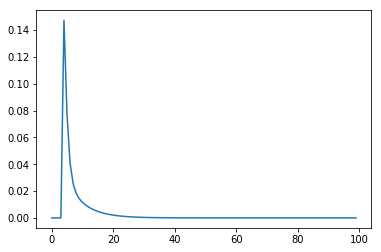

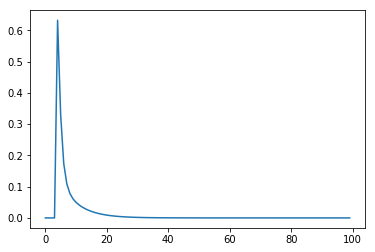

In [25]:
norm_factor=np.amax(X)
print(norm_factor)

X_scaled=X/norm_factor
print(X)
print(X_scaled)
print(X.max(axis=0))
print(X_scaled.max(axis=0))

plt.plot(X[0])
plt.figure()
plt.plot(X_scaled[0])

In [26]:
foo=np.amax(X_scaled)
print(foo)

1.0


In [4]:
file=h5py.File('FinerParameterSpace500events1000photons100binsTrainingLibrary_15x15.hdf5', 'r')

X2=[]
Y2=[]
labels2=[]
counter=0
for groups in file.values():

    for subgroup in groups.values():

        for event in subgroup.values():
            if counter<500:
                
                if event.name[-5:]=="input":
                    X2.append(event[:])
                    labels2.append(event.name)
                elif event.name[-6:]=="output":
                    Y2.append(event[:])
                counter+=1
            else:
                break

file.close()

In [5]:
file=h5py.File('NarrowerParameterSpace500events5000photons100binsTrainingLibrary.hdf5', 'r')

X3=[]
Y3=[]
labels3=[]
counter=0
for groups in file.values():

    for subgroup in groups.values():

        for event in subgroup.values():
            if counter<500:
                
                if event.name[-5:]=="input":
                    X3.append(event[:])
                    labels3.append(event.name)
                elif event.name[-6:]=="output":
                    Y3.append(event[:])
                counter+=1
            else:
                break

file.close()




In [6]:
file=h5py.File('NarrowerParameterSpace500events5000photons100binsTrainingLibrary.hdf5', 'r')

X4=[]
Y4=[]
labels4=[]
counter=0
for groups in file.values():

    for subgroup in groups.values():

        for event in subgroup.values():
            if counter<500:
                
                if event.name[-5:]=="input":
                    data=event[:]
                    data=np.asarray(data)
                    norm_factor=np.trapz(data, dx=0.1)
                    #norm_factor=max(data)
                    data_normalized=data/norm_factor
                    #print(data_normalized)
                    X4.append(data_normalized)
                    labels4.append(event.name)
                elif event.name[-6:]=="output":
                    Y4.append(event[:])
                counter+=1
            else:
                break

file.close()

In [12]:
file=h5py.File('FinerParameterSpace500events10000photons100binsTrainingLibrary_20x20.hdf5', 'r')
integration_vals=[1.25, 3.75, 6.25, 8.75, 11.25, 13.75, 16.25, 18.75, 21.25, 23.75, 26.25, 28.75, 31.25, 33.75, 36.25, 38.75, 41.25, 43.75, 46.25, 48.75, 51.25, 53.75, 56.25, 58.75, 61.25, 63.75, 66.25, 68.75, 71.25, 73.75, 76.25, 78.75, 81.25, 83.75, 86.25, 88.75, 91.25, 93.75, 96.25, 98.75, 101.25, 103.75, 106.25, 108.75, 111.25, 113.75, 116.25, 118.75, 121.25, 123.75, 126.25, 128.75, 131.25, 133.75, 136.25, 138.75, 141.25, 143.75, 146.25, 148.75, 151.25, 153.75, 156.25, 158.75, 161.25, 163.75, 166.25, 168.75, 171.25, 173.75, 176.25, 178.75, 181.25, 183.75, 186.25, 188.75, 191.25, 193.75, 196.25, 198.75, 201.25, 203.75, 206.25, 208.75, 211.25, 213.75, 216.25, 218.75, 221.25, 223.75, 226.25, 228.75, 231.25, 233.75, 236.25, 238.75, 241.25, 243.75, 246.25, 248.75]
X5=[]
Y5=[]
labels5=[]
counter=0
for groups in file.values():

    for subgroup in groups.values():

        for event in subgroup.values():
            if 'event0' in event.name:
                
                if event.name[-5:]=="input":
                    data=event[:]
                    data=np.asarray(data)
                    norm_factor=np.trapz(data, integration_vals)
                    data_normalized=data/norm_factor
                    #print(data_normalized)
                    X5.append(data_normalized)
                    labels5.append(event.name)
                elif event.name[-6:]=="output":
                    Y5.append(event[:])
                

file.close()

1.0

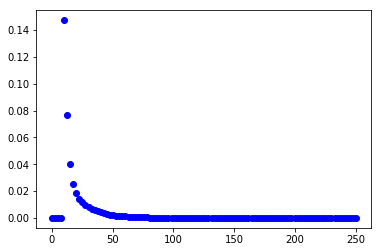

In [14]:
x=np.linspace(0,250,100)
plt.plot(x,X[0], 'bo')

np.trapz(X[-1], x)

[ 0.00000000e+00 -1.52549177e-03 -3.33199518e-03 -3.05098354e-03
  1.44243702e-02  5.48930753e-03 -1.47346193e-04 -1.08084704e-03
 -8.98957566e-04 -1.93108774e-03 -8.73239161e-04 -2.34650395e-03
 -9.68944963e-04 -1.08103202e-03 -9.82226815e-04 -1.11500720e-03
 -5.45266416e-04 -9.01662631e-04 -6.37187562e-04 -5.30072200e-04
 -1.91863692e-04 -8.77987417e-04 -2.69298173e-04  1.00911007e-04
  1.05615687e-04 -3.81186767e-04  4.08558867e-05 -1.17580341e-04
 -1.77399150e-04  1.91376981e-05 -1.32537431e-04 -1.92862807e-04
 -4.31186383e-05  7.43797167e-05  1.98552936e-04 -3.29338800e-05
  1.41791180e-04 -1.21045369e-04 -1.39610807e-04  8.55674457e-05
  7.23094435e-05 -9.94724168e-05  1.14933023e-05  4.36369483e-05
 -3.26877364e-06 -8.92714209e-05  2.63338116e-05 -1.78909255e-05
  1.88055754e-05 -2.42527208e-05 -2.67150300e-05  1.13486964e-05
 -3.05542151e-05  8.10436291e-06  6.84865566e-06  5.78751036e-06
  4.89078118e-06  4.13299313e-06  3.49261837e-06  2.95146464e-06
  2.49415843e-06  2.10770

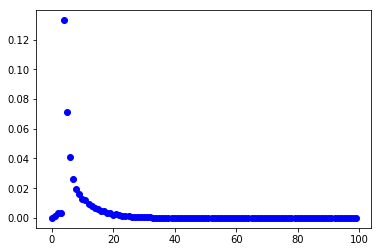

In [17]:
plt.plot(X5[0], 'bo')

np.trapz(X5[0], dx=2.5)

print(X[0]-X5[0])

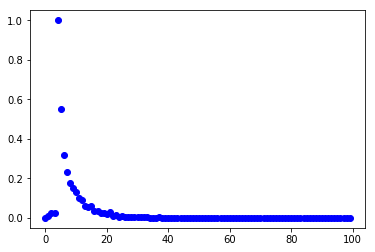

In [9]:
plt.plot(X3[0]/max(X3[0]), 'bo')

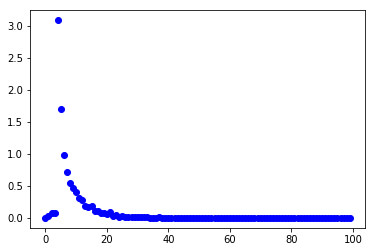

In [10]:
plt.plot(X4[0], 'bo')

In [11]:
np.trapz(X4[0],dx=0.1)

1.0